In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import pdb

## 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 $ \lambda $ を用意して、以下の式により更新していきます。  
この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。  
$$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$
ここで $ k(x_i, x_j) $ はカーネル関数です。線形カーネルの場合は次のようになります。  
他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。
条件として、更新毎に $ \lambda_i >= 0 $ を満たす必要があります。満たさない場合は $ \lambda_i = 0 $とします。

## 【問題2】サポートベクターの決定
計算したラグランジュ乗数 $ \lambda $ が設定した閾値より大きいサンプルをサポートベクターとして扱います。  
推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。  
閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

## 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $ f(x) $ の符号が分類結果です。
$$
f(x) = \sum_{n=1}^{N}\lambda_n y_{sv\_n} k(x, s_n)
$$

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X_train, y_train, model, step=0.01, target_names=['0', '1']):

    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), 
                                    np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title('dicision region')
    plt.xlabel('f0')
    plt.ylabel('f1')
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.scatter(X_train[svm.support_vec_idx,0], X_train[svm.support_vec_idx,1], s=80, c='yellow')
    #plt.xlim([-10, 10])
    #plt.ylim([-10, 10])
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [3]:
class ScratchSVMClassifier():
    def __init__(self, num_iter=5000, lr=0.001, kernel='linear', threshold=1e-5):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        
        self.X = None
        self.y = None
        self.m = None    # number of samples
        self.lmd = None  # lambda
        self.support_vec_idx = None
        
        
    def kernel_func(self, X1, X2):
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'poly':
            gamma = 5
            theta = 2
            d = 2
            return gamma * (np.dot(X1, X2.T) + theta)**d

        
    def fit(self, X, y):
        self.X = X
        self.y = y.reshape(-1,)
        self.m = len(self.X)
        self.lmd = np.random.rand(self.m) * 0.1
        
        for _ in range(self.iter):
            self.lmd += self.lr * (1 - self.y*np.sum(self.y*self.lmd*self.kernel_func(self.X, self.X), axis=1))
            self.lmd[self.lmd<0] = 0
            self.support_vec_idx = np.where(self.lmd>self.threshold)[0]
            #print(len(self.support_vec_idx))
        #print(self.lmd)
        
    
    def predict(self, X_test):
        f = np.sum(self.y[self.support_vec_idx]*self.lmd[self.support_vec_idx]*self.kernel_func(X_test, self.X[self.support_vec_idx,:]), axis=1)
        f = np.where(f<0, -1, 1)
        return f

## 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。  
scikit-learnによる実装と比べ、正しく動いているかを確認してください。  
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

## 【問題5】決定領域の可視化
決定領域を可視化してください。  
サポートベクトルは異なる色で示してください。

## 【問題6】多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。
$$
k(x_i, x_j) = \gamma(x_{i}^{T} x_j + \theta_0)^{d}
$$

In [4]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
svm = ScratchSVMClassifier(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

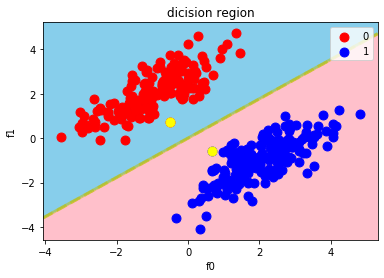

In [6]:
decision_region(X_train, y_train, svm)

In [7]:
svm = ScratchSVMClassifier(num_iter=5000, lr=0.000001, kernel='poly')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

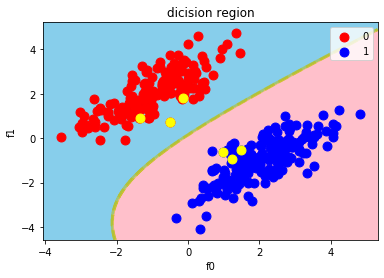

In [8]:
decision_region(X_train, y_train, svm)

### sklearnによる実装との比較

In [9]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

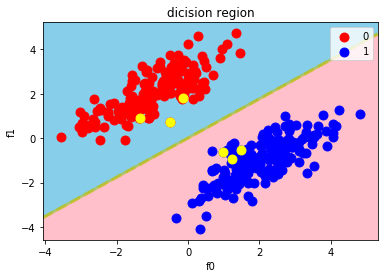

In [10]:
decision_region(X_train, y_train, svc)